# Introduction to GeoPandas


## Table of Contents

1. [Points, lines and polygons](#GeoDataFrames)<br>
2. [Spatial relationships](#spatial)<br>
3. [London boroughs](#boroughs)<br>
    3.1. [Load geodpatial data](#load1)<br>
    3.2. [Explore data](#explore1)<br>
4. [Open Street Map data (OSM)](#osm)<br>
    4.1. [Load data](#load2)<br>
    4.2. [Explore data](#explore2)<br>


<div class="alert alert-danger" style="font-size:100%">
If you are using <b>Watson Studio</b> to run the workshop you will need to add the project token to your notebook that you created earlier to be able to access the shape files from your Cloud Object Store (COS). 

Click the 3 dots at the top of the notebook to insert the project token. This will create a new cell in the notebook that you will need to run first before continuing with the rest of the notebook. If you are sharing this notebook you should remove this cell, else anyone can use you Cloud Object Storage from this project.

If you cannot find the new cell it is probably at the top of this notebook. Scroll up, run the cell and continue with the rest of the notebook

</div> 

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon
import matplotlib.pyplot as plt

%matplotlib inline

<a id="GeoDataFrames"></a>
## 1. Points, lines and polygons

A [`GeoDataSeries`](http://geopandas.org/data_structures.html) is a vector where each row is a set of shapes corresponding to one observation. A row may consist of only one shape (like a single polygon) or multiple shapes that are meant to be thought of as one observation.

A `GeoDataFrame` is very similar to a Pandas `DataFrame`, but has an additional column with the shape or `geometry`. You can load a file, or create your own `GeoDataFrame`. 

Below the latitude and longitude of 5 cities are used to create a `POINT` geometry variable that is used to create a `GeoDataFrame` from a `DataFrame`: 

In [2]:
df = pd.DataFrame({'city':       ['London','Manchester','Birmingham','Leeds','Glasgow'],
        'population': [9787426,  2553379,     2440986,    1777934, 1209143],
        'area':       [1737.9,   630.3,       598.9,      487.8,   368.5 ],
        'latitude':   [51.50853, 53.48095,    52.48142,   53.79648,55.86515],
        'longitude':  [-0.12574, -2.23743,    -1.89983,   -1.54785,-4.25763]})

df['geometry']  = list(zip(df.longitude, df.latitude))

df['geometry'] = df['geometry'].apply(Point)

cities = gpd.GeoDataFrame(df, geometry='geometry')
cities.head()

,city,population,area,latitude,longitude,geometry
0,London,9787426,1737.9,51.50853,-0.12574,POINT (-0.12574 51.50853)
1,Manchester,2553379,630.3,53.48095,-2.23743,POINT (-2.23743 53.48095)
2,Birmingham,2440986,598.9,52.48142,-1.89983,POINT (-1.89983 52.48142)
3,Leeds,1777934,487.8,53.79648,-1.54785,POINT (-1.54785 53.79648)
4,Glasgow,1209143,368.5,55.86515,-4.25763,POINT (-4.25763 55.86515)


Creating a basic map from this data is similar to creating a plot from a Pandas DataFrame by using `.plot()`. Below the column name defines what to use for the colours in the map. (We will come back to creating and editing more maps later) 

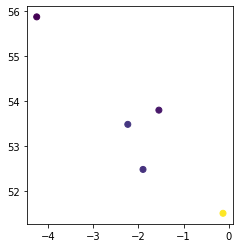

In [3]:
cities.plot(column='population');

As `cities` is still a DataFrame you can apply the same data manipulations, for instance:

In [4]:
cities['population'].mean()

3553773.6

In [6]:
cities['area'].min()

368.5

In [7]:
cities['density'] = cities['population']/cities['area']
cities

,city,population,area,latitude,longitude,geometry,density
0,London,9787426,1737.9,51.50853,-0.12574,POINT (-0.12574 51.50853),5631.754416
1,Manchester,2553379,630.3,53.48095,-2.23743,POINT (-2.23743 53.48095),4051.053467
2,Birmingham,2440986,598.9,52.48142,-1.89983,POINT (-1.89983 52.48142),4075.782267
3,Leeds,1777934,487.8,53.79648,-1.54785,POINT (-1.54785 53.79648),3644.801148
4,Glasgow,1209143,368.5,55.86515,-4.25763,POINT (-4.25763 55.86515),3281.256445


But there are additional methods you can use (from the [geopandas documentation](http://geopandas.org/data_structures.html#overview-of-attributes-and-methods)):

### Attributes
* `area`: shape area
* `bounds`: tuple of max and min coordinates on each axis for each shape
* `total_bounds`: tuple of max and min coordinates on each axis for entire GeoSeries
* `geom_type`: type of geometry
* `is_valid`: tests if coordinates make a shape that is reasonable geometric shape

### Basic Methods
* `distance(other)`: returns Series with minimum distance from each entry to other
* `centroid`: returns GeoSeries of centroids
* `representative_point()`: returns GeoSeries of points that are guaranteed to be within each geometry. It does NOT return centroids
* `to_crs()`: change coordinate reference system
* `plot()`: plot GeoSeries

### Relationship Tests
* `geom_almost_equals(other)`: is shape almost the same as other (good when floating point precision issues make shapes slightly different)
* `contains(other)`: is shape contained within other
* `intersects(other)`: does shape intersect other


We can explore a few of these with the cities data:

In [9]:
cities['area']

0    1737.9
1     630.3
2     598.9
3     487.8
4     368.5
Name: area, dtype: float64

In [10]:
cities.total_bounds

array([-4.25763, 51.50853, -0.12574, 55.86515])

In [11]:
cities.geom_type

0    Point
1    Point
2    Point
3    Point
4    Point
dtype: object

In [12]:
cities.distance(cities.geometry[0])

0    0.000000
1    2.889580
2    2.023341
3    2.693903
4    6.004386
dtype: float64

For the other attributes and methods we need some more data. 

* A line between 2 cities by squeezing out the geometry and then creating a LineString
* Circles around the cities by adding a buffer around the points

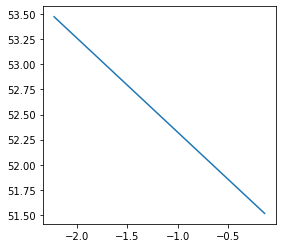

In [13]:
london = cities.loc[cities['city'] == 'London', 'geometry'].squeeze()
manchester = cities.loc[cities['city'] == 'Manchester', 'geometry'].squeeze()

line = gpd.GeoSeries(LineString([london, manchester]))
line.plot();

In [14]:
cities2 = cities.copy()
cities2['geometry'] = cities2.buffer(1)
cities2 = cities2.drop([1, 2])
cities2.head()

,city,population,area,latitude,longitude,geometry,density
0,London,9787426,1737.9,51.50853,-0.12574,"POLYGON ((0.87426 51.50853, 0.869444726672197 ...",5631.754416
3,Leeds,1777934,487.8,53.79648,-1.54785,"POLYGON ((-0.5478499999999999 53.79648, -0.552...",3644.801148
4,Glasgow,1209143,368.5,55.86515,-4.25763,"POLYGON ((-3.25763 55.86515, -3.26244527332780...",3281.256445


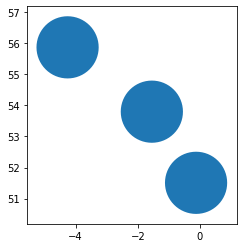

In [15]:
cities2.plot();

And plot all of them together:

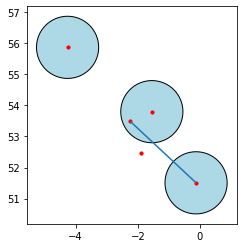

In [16]:
base = cities2.plot(color='lightblue', edgecolor='black')
cities.plot(ax=base, marker='o', color='red', markersize=10);
line.plot(ax=base);

Polygons can be of any shape as you will see later in the workshop, using circles here as a quick example. 

Polygons can contain holes. Let's subtract a small circle from three larger ones to see what that looks like:

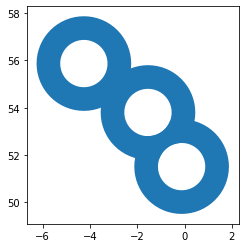

In [17]:
cities3 = cities.copy()
cities3['geometry'] = cities3.buffer(2)
cities3 = cities3.drop([1, 2])

gpd.overlay(cities3, cities2, how='difference').plot();

With these new shapes let's explore some more methods:

In [18]:
cities2.area

0    3.136548
3    3.136548
4    3.136548
dtype: float64

In [19]:
cities2.bounds

,minx,miny,maxx,maxy
0,-1.12574,50.50853,0.87426,52.50853
3,-2.54785,52.79648,-0.54785,54.79648
4,-5.25763,54.86515,-3.25763,56.86515


In [20]:
cities2.centroid

0    POINT (-0.1257399999999998 51.50853000000002)
3              POINT (-1.547849999999999 53.79648)
4     POINT (-4.257630000000002 55.86515000000001)
dtype: object

In [21]:
cities3.representative_point()

0    POINT (-0.1257399999999997 51.50853000000001)
3               POINT (-1.54785 53.79648000000001)
4               POINT (-4.25763 55.86515000000001)
dtype: object

<a id="spatial"></a>
## 2. Spatial relationships

What can you do with geospatial relationships?  

There are several functions to check geospatial relationships between geometries: `equals`, `contains`, `crosses`, `disjoint`,`intersects`,`overlaps`,`touches`,`within` and `covers`. These all use the `shapely` package about which you can read more [here](https://shapely.readthedocs.io/en/stable/manual.html#predicates-and-relationships) and some more background on spatial relationships [here](https://en.wikipedia.org/wiki/Spatial_relation).

A few examples:

In [22]:
cities2.contains(cities.geometry[0])

0     True
3    False
4    False
dtype: bool

In [23]:
cities2.contains(london)

0     True
3    False
4    False
dtype: bool

In [24]:
cities2[cities2.contains(london)]

,city,population,area,latitude,longitude,geometry,density
0,London,9787426,1737.9,51.50853,-0.12574,"POLYGON ((0.87426 51.50853, 0.869444726672197 ...",5631.754416


In [25]:
cities2[cities2.contains(manchester)]

,city,population,area,latitude,longitude,geometry,density
3,Leeds,1777934,487.8,53.79648,-1.54785,"POLYGON ((-0.5478499999999999 53.79648, -0.552...",3644.801148


The inverse of `contains`:

In [26]:
cities[cities.within(cities2)]

,city,population,area,latitude,longitude,geometry,density
0,London,9787426,1737.9,51.50853,-0.12574,POINT (-0.12574 51.50853),5631.754416
3,Leeds,1777934,487.8,53.79648,-1.54785,POINT (-1.54785 53.79648),3644.801148
4,Glasgow,1209143,368.5,55.86515,-4.25763,POINT (-4.25763 55.86515),3281.256445


In [27]:
cities2.intersects(line)

0     True
3    False
4    False
dtype: bool

In [28]:
cities2[cities2.crosses(line)]

,city,population,area,latitude,longitude,geometry,density
0,London,9787426,1737.9,51.50853,-0.12574,"POLYGON ((0.87426 51.50853, 0.869444726672197 ...",5631.754416


In [29]:
cities2[cities2.disjoint(london)]

,city,population,area,latitude,longitude,geometry,density
3,Leeds,1777934,487.8,53.79648,-1.54785,"POLYGON ((-0.5478499999999999 53.79648, -0.552...",3644.801148
4,Glasgow,1209143,368.5,55.86515,-4.25763,"POLYGON ((-3.25763 55.86515, -3.26244527332780...",3281.256445


<a id="boroughs"></a>
## 3. London boroughs

<a id="load1"></a>
### 3.1 Load geospatial data

Geospatial data comes in many formats, but with GeoPandas you can read most files with just one command. For example this geojson file with the London boroughs: 

In [30]:
# load data from a url
boroughs = gpd.read_file("https://skgrange.github.io/www/data/london_boroughs.json")
boroughs.head()

,id,name,code,area_hectares,inner_statistical,geometry
0,1,Kingston upon Thames,E09000021,3726.117,0,(POLYGON ((-0.330679062942453 51.3290110106029...
1,2,Croydon,E09000008,8649.441,0,(POLYGON ((-0.064021239620113 51.3186376598749...
2,3,Bromley,E09000006,15013.487,0,"(POLYGON ((0.012130938509177 51.2995990596564,..."
3,4,Hounslow,E09000018,5658.541,0,"(POLYGON ((-0.244562394525054 51.48870217634, ..."
4,5,Ealing,E09000009,5554.428,0,(POLYGON ((-0.411832689731467 51.5340838625761...


<a id="explore1"></a>
### 3.2 Explore  data

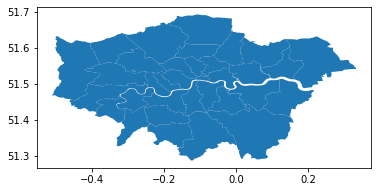

In [31]:
boroughs.plot();

Adding a column will colour the map based on the classes in this column:

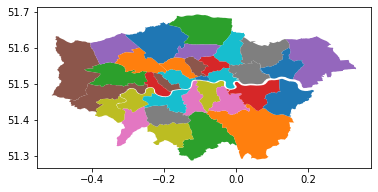

In [32]:
boroughs.plot(column='code');

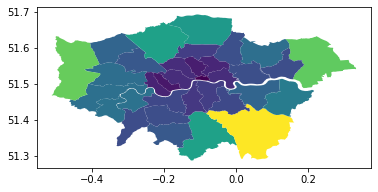

In [33]:
boroughs.plot(column='area_hectares');

The boroughs are made up of many districts that you might want to combine. For this example this can be done by adding a new column and then use `.dissolve()`:

In [34]:
boroughs['all'] = 1
allboroughs = boroughs.dissolve(by='all',aggfunc='sum')
allboroughs.head()

,geometry,id,area_hectares,inner_statistical
all,,,,
1,"POLYGON ((-0.064021239620113 51.3186376598749,...",561,159469.725,14


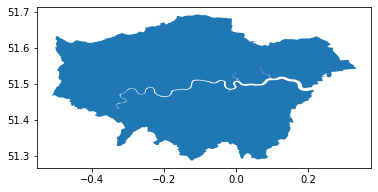

In [35]:
allboroughs.plot();

To change the size of the map and remove the box around the map, run the below:

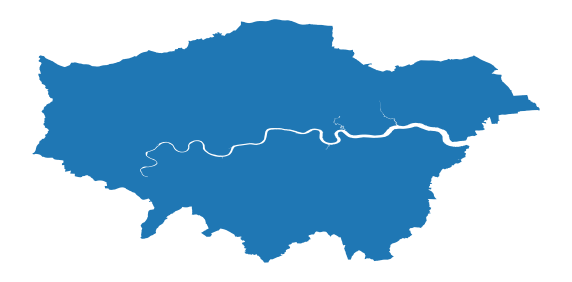

In [36]:
[fig, ax] = plt.subplots(1, figsize=(10, 6))
allboroughs.plot(ax=ax);
ax.axis('off');

Let's combine the data from the Pandas notebook with the boroughs GeoDataFrame:

In [37]:
df = pd.read_csv('../data/london-borough-profiles.csv',encoding = 'unicode_escape')

<div class="alert alert-danger" style="font-size:100%">
If you are using <b>Watson Studio</b> to run the workshop you will get an error with the above, because you have no local files in the data folder. First store the data in your Cloud Object Store (COS) by adding the files in the menu on the right of the notebook (if you see no menu, click the <b><font face="Courier">1010</font></b> button at the top first) and then load the data by following these steps:

<ul>
  <li>Activate the below cell, move the cursor to the empty line under  <b><font face="Courier"># add data</font></b></li>
  <li>Click on <b><font face="Courier">Insert to code</font></b> under the file from the right menu</li>
  <li>Select <b><font face="Courier">Insert pandas DataFrame</font></b></li>
  <li>Code to load the file will be inserted</li>
  <li>Change the default name of the data from <b><font face="Courier">df_data_1</font></b> to <b><font face="Courier">df</font></b> at the bottom two lines of the inserted code and add <b><font face="Courier">encoding = 'unicode_escape'</font></b> </li>
    <li>Then run the cell to load the data and continue with the rest of the notebook</li>
  </ul>
</div>

In [ ]:
# add data


In [38]:
df.head()

,Code,Area_name,Inner/_Outer_London,GLA_Population_Estimate_2017,GLA_Household_Estimate_2017,Inland_Area_(Hectares),Population_density_(per_hectare)_2017,"Average_Age,_2017","Proportion_of_population_aged_0-15,_2015","Proportion_of_population_of_working-age,_2015",...,Happiness_score_2011-14_(out_of_10),Anxiety_score_2011-14_(out_of_10),Childhood_Obesity_Prevalance_(%)_2015/16,People_aged_17+_with_diabetes_(%),Mortality_rate_from_causes_considered_preventable_2012/14,Political_control_in_council,Proportion_of_seats_won_by_Conservatives_in_2014_election,Proportion_of_seats_won_by_Labour_in_2014_election,Proportion_of_seats_won_by_Lib_Dems_in_2014_election,Turnout_at_2014_local_elections
0,E09000001,City of London,Inner London,8800.0,5326.0,290.0,30.3,43.2,11.4,73.1,...,6.0,5.6,NaN,2.6,129.0,NaN,NaN,NaN,NaN,NaN
1,E09000002,Barking and Dagenham,Outer London,209000.0,78188.0,3611.0,57.9,32.9,27.2,63.1,...,7.1,3.1,28.5,7.3,228.0,Lab,0.0,100.0,0.0,36.5
2,E09000003,Barnet,Outer London,389600.0,151423.0,8675.0,44.9,37.3,21.1,64.9,...,7.4,2.8,20.7,6.0,134.0,Cons,50.8,NaN,1.6,40.5
3,E09000004,Bexley,Outer London,244300.0,97736.0,6058.0,40.3,39.0,20.6,62.9,...,7.2,3.3,22.7,6.9,164.0,Cons,71.4,23.8,0.0,39.6
4,E09000005,Brent,Outer London,332100.0,121048.0,4323.0,76.8,35.6,20.9,67.8,...,7.2,2.9,24.3,7.9,169.0,Lab,9.5,88.9,1.6,36.3


In [39]:
boroughs.head()

,id,name,code,area_hectares,inner_statistical,geometry,all
0,1,Kingston upon Thames,E09000021,3726.117,0,(POLYGON ((-0.330679062942453 51.3290110106029...,1
1,2,Croydon,E09000008,8649.441,0,(POLYGON ((-0.064021239620113 51.3186376598749...,1
2,3,Bromley,E09000006,15013.487,0,"(POLYGON ((0.012130938509177 51.2995990596564,...",1
3,4,Hounslow,E09000018,5658.541,0,"(POLYGON ((-0.244562394525054 51.48870217634, ...",1
4,5,Ealing,E09000009,5554.428,0,(POLYGON ((-0.411832689731467 51.5340838625761...,1


The columns to join the two tables on are `code` and `Code`. To use the [`join` method](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html), first the index of both tables has to be set to this column. 

The below adds the columns from `df` to `boroughs`:

In [40]:
boroughs = boroughs.set_index('code').join(df.set_index('Code'))
boroughs.head()

,id,name,area_hectares,inner_statistical,geometry,all,Area_name,Inner/_Outer_London,GLA_Population_Estimate_2017,GLA_Household_Estimate_2017,...,Happiness_score_2011-14_(out_of_10),Anxiety_score_2011-14_(out_of_10),Childhood_Obesity_Prevalance_(%)_2015/16,People_aged_17+_with_diabetes_(%),Mortality_rate_from_causes_considered_preventable_2012/14,Political_control_in_council,Proportion_of_seats_won_by_Conservatives_in_2014_election,Proportion_of_seats_won_by_Labour_in_2014_election,Proportion_of_seats_won_by_Lib_Dems_in_2014_election,Turnout_at_2014_local_elections
E09000001,33,City of London,314.942,1,"(POLYGON ((-0.111574406694964 51.5107549197, -...",1,City of London,Inner London,8800.0,5326.0,...,6.0,5.6,NaN,2.6,129.0,NaN,NaN,NaN,NaN,NaN
E09000002,32,Barking and Dagenham,3779.934,0,(POLYGON ((0.07316567606867801 51.529370200593...,1,Barking and Dagenham,Outer London,209000.0,78188.0,...,7.1,3.1,28.5,7.3,228.0,Lab,0.0,100.0,0.0,36.5
E09000003,10,Barnet,8674.837,0,(POLYGON ((-0.199896404443971 51.6701668576827...,1,Barnet,Outer London,389600.0,151423.0,...,7.4,2.8,20.7,6.0,134.0,Cons,50.8,NaN,1.6,40.5
E09000004,15,Bexley,6428.649,0,"(POLYGON ((0.120210839063794 51.5114446653239,...",1,Bexley,Outer London,244300.0,97736.0,...,7.2,3.3,22.7,6.9,164.0,Cons,71.4,23.8,0.0,39.6
E09000005,9,Brent,4323.270,0,(POLYGON ((-0.196568746300418 51.5276540106305...,1,Brent,Outer London,332100.0,121048.0,...,7.2,2.9,24.3,7.9,169.0,Lab,9.5,88.9,1.6,36.3


<div class="alert alert-success">
 <b>EXERCISES</b> <br/> 
  <ol>
  <li>Create a map that shows two regions: Inner and Outer London. </li>
  <li>Create a map of the average gender pay gap for each borough.  </li>
  <li>Create a map or maps with the columns that you are curious about. </li>    
 </ul> 

<b>Tip</b>: you can pick any of the color maps from [here](https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html) to use in your maps.

</div>  




In [ ]:
# answer 1: Inner and Outer London map (add as many cells as you need)


In [42]:
# %load https://raw.githubusercontent.com/IBMDeveloperUK/foss4g-geopandas/master/answers/geo_answer1a.py
boroughs2 = boroughs.dissolve(by='Inner/_Outer_London',aggfunc='mean')
boroughs2.head()


,geometry,id,area_hectares,inner_statistical,all,GLA_Population_Estimate_2017,GLA_Household_Estimate_2017,Inland_Area_(Hectares),Population_density_(per_hectare)_2017,"Average_Age,_2017",...,Worthwhileness_score_2011-14_(out_of_10),Happiness_score_2011-14_(out_of_10),Anxiety_score_2011-14_(out_of_10),Childhood_Obesity_Prevalance_(%)_2015/16,People_aged_17+_with_diabetes_(%),Mortality_rate_from_causes_considered_preventable_2012/14,Proportion_of_seats_won_by_Conservatives_in_2014_election,Proportion_of_seats_won_by_Labour_in_2014_election,Proportion_of_seats_won_by_Lib_Dems_in_2014_election,Turnout_at_2014_local_elections
Inner/_Outer_London,,,,,,,,,,,,,,,,,,,,,
Inner London,"(POLYGON ((0.075487345438734 51.5298237426242,...",23.857143,2341.884643,1.0,1.0,252550.000000,108752.928571,2280.5,110.850000,35.550000,...,7.478571,7.135714,3.578571,23.684615,5.085714,184.785714,23.646154,69.207692,3.507692,37.446154
Outer London,(POLYGON ((-0.024847351506038 51.4855462016976...,11.947368,6667.544211,0.0,1.0,278931.578947,109443.210526,6594.0,47.673684,36.984211,...,7.631579,7.263158,3.200000,21.963158,6.394737,162.578947,38.915789,48.544444,8.721053,39.794737


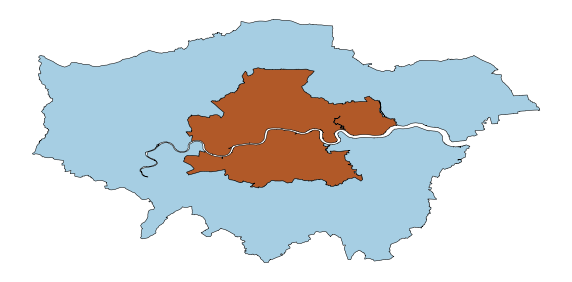

In [44]:
# %load https://raw.githubusercontent.com/IBMDeveloperUK/foss4g-geopandas/master/answers/geo_answer1b.py
[fig, ax] = plt.subplots(1, figsize=(10, 6))
boroughs2.plot(column='id', cmap='Paired', linewidth=0.5, edgecolor='black', legend=False, ax=ax);
ax.axis('off');


In [ ]:
# answer 2: average gender pay gap map


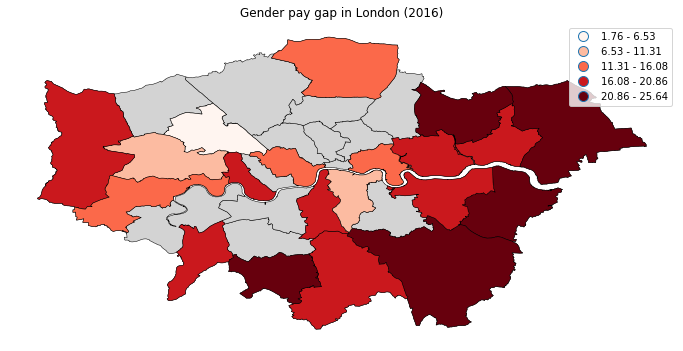

In [46]:
# %load https://raw.githubusercontent.com/IBMDeveloperUK/foss4g-geopandas/master/answers/geo_answer2.py
boroughs['paygap'] = \
    ((boroughs['Gross_Annual_Pay_-_Male_(2016)'] - boroughs['Gross_Annual_Pay_-_Female_(2016)'])/ \
    boroughs['Gross_Annual_Pay_-_Male_(2016)']) * 100

[fig,ax] = plt.subplots(1, figsize=(12, 8))

boroughs.plot(ax=ax, color="lightgrey", edgecolor='black', linewidth=0.5)

boroughs.dropna().plot(column='paygap', cmap='Reds', edgecolor='black', linewidth=0.5,
               legend=True, ax=ax, scheme='equal_interval');
ax.axis('off');
ax.set_title('Gender pay gap in London (2016)');


In [ ]:
# answer 3: your turn to play!


<a id="osm"></a>
## 4. Open Street Map data (OSM)

<a id="load2"></a>
### 4.1 Load OSM data

The Open Street Map data is pre-processed in this [notebook]().

Data is downloaded from http://download.geofabrik.de/europe/great-britain.html and a more detailed decription of the data is [here](http://download.geofabrik.de/osm-data-in-gis-formats-free.pdf).

The data format is a shape file that consists of several files combined into one zip file that can be read directly with GeoPandas:

In [47]:
pois = gpd.read_file("zip://../data/london_pois.zip")

<div class="alert alert-danger" style="font-size:100%">
If you are using <b>Watson Studio</b> to run the workshop you will get an error with the above, because you have no local files in the data folder. First store the file <b><font face="Courier">london_pois.zip</font></b> in your Cloud Object Store (COS) through the menu at the right of the notebook (if you see no menu, click the <b><font face="Courier">1010</font></b> button at the top first). Then load the data into the notebook by running the following two cells (<b>do not forget to uncomment the second cell</b>):
</div> 

In [ ]:
# define the helper function 
def download_file_to_local(project_filename, local_file_destination=None, project=None):
    """
    Uses project-lib to get a bytearray and then downloads this file to local.
    Requires a valid `project` object.
    
    Args:
        project_filename str: the filename to be passed to get_file
        local_file_destination: the filename for the local file if different
        
    Returns:
        0 if everything worked
    """
    
    project = project
    
    # get the file
    print("Attempting to get file {}".format(project_filename))
    _bytes = project.get_file(project_filename).read()
    
    # check for new file name, download the file
    print("Downloading...")
    if local_file_destination==None: local_file_destination = project_filename
    
    with open(local_file_destination, 'wb') as f: 
        f.write(bytearray(_bytes))
        print("Completed writing to {}".format(local_file_destination))
        
    return 0

In [ ]:
#download_file_to_local('london_pois.zip', project=project)
#pois = gpd.read_file("zip://./london_pois.zip")

In [48]:
pois.head()

,osm_id,code,fclass,name,geometry
0,108042,2304,pub,Simmons,POINT (-0.1355294 51.5235359)
1,108539,2566,bicycle_rental,Windsor Terrace,POINT (-0.09338780000000001 51.5291251)
2,283885,2204,park,Ecology Park,POINT (0.0155831 51.494974)
3,451152,2304,pub,The Dignity,POINT (-0.1946078 51.6008404)
4,451153,2301,restaurant,Central Restaurant,POINT (-0.1935029 51.6020306)


<a id="explore2"></a>
### 4.2 Explore OSM data

In [49]:
pois.size

303130

In [50]:
pois['fclass'].unique()

array(['pub', 'bicycle_rental', 'park', 'restaurant', 'post_box',
       'post_office', 'library', 'memorial', 'telephone',
       'public_building', 'fountain', 'artwork', 'museum', 'police',
       'toilet', 'cafe', 'pitch', 'recycling', 'bar', 'attraction', 'atm',
       'swimming_pool', 'kindergarten', 'cinema', 'waste_basket',
       'monument', 'college', 'university', 'supermarket', 'graveyard',
       'hotel', 'laundry', 'courthouse', 'school', 'sports_centre',
       'pharmacy', 'convenience', 'bank', 'beverages', 'fast_food',
       'fire_station', 'water_tower', 'doctors', 'department_store',
       'theatre', 'viewpoint', 'playground', 'newsagent', 'gift_shop',
       'clothes', 'recycling_paper', 'veterinary', 'wastewater_plant',
       'dentist', 'recycling_glass', 'chemist', 'hospital', 'town_hall',
       'tourist_info', 'bicycle_shop', 'car_rental', 'bakery',
       'travel_agent', 'doityourself', 'windmill', 'comms_tower',
       'car_sharing', 'camera_surveillance', 

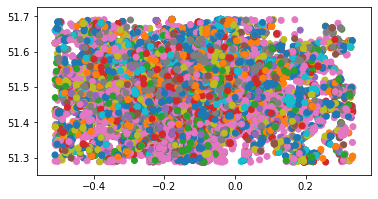

In [51]:
pois.plot(column='fclass');

In [52]:
pois.groupby('fclass').count()

,osm_id,code,name,geometry
fclass,,,,
archaeological,33,33,31,33
arts_centre,37,37,35,37
artwork,622,622,447,622
atm,1418,1418,97,1418
attraction,162,162,150,162
bakery,338,338,320,338
bank,684,684,657,684
bar,627,627,604,627
battlefield,1,1,1,1


In [65]:
pois[pois['fclass']=='zoo']

,osm_id,code,fclass,name,geometry
14363,715694321,2743,zoo,Beaver Water World,POINT (0.0173499 51.2891627)
20065,1333615707,2743,zoo,Old Macdonald Farm,POINT (0.2375653 51.6258833)
42765,4213593185,2743,zoo,Amazu,POINT (-0.3166278 51.3495078)
44139,4324851538,2743,zoo,None,POINT (-0.3864585 51.5926572)


Let's count and plot the number of pubs by borough by:

* checking the coordinate systems of the maps to combine. They need to be the same to use them together.
* extracting the pubs from the `pois` DataFrame
* joining the tables into a temporary table
* counting the number of pubs in each borough
* merging this new table back into the `boroughs` DataFrame

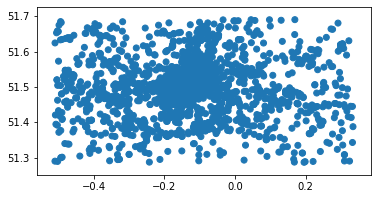

In [53]:
pois[pois.fclass=='pub'].plot(column='fclass');

The coordinate reference system (CRS) determines how the two-dimensional (planar) coordinates of the geometry objects should be related to actual places on the (non-planar) earth.

In [54]:
print(pois.crs)
print(boroughs.crs)

{'init': 'epsg:4326'}
{'init': 'epsg:4326'}


In [55]:
pubs = pois[pois['fclass']=='pub']
pubs.head()

,osm_id,code,fclass,name,geometry
0,108042,2304,pub,Simmons,POINT (-0.1355294 51.5235359)
3,451152,2304,pub,The Dignity,POINT (-0.1946078 51.6008404)
5,451154,2304,pub,The Catcher in the Rye,POINT (-0.1960052 51.5995863)
6,451271,2304,pub,The Tally Ho,POINT (-0.1765046 51.6141038)
12,12242503,2304,pub,Railway Bell,POINT (0.0279621 51.5920158)


In [56]:
pubs2 = gpd.sjoin(boroughs,pubs) 
pubs2.head()

,id,name_left,area_hectares,inner_statistical,geometry,all,Area_name,Inner/_Outer_London,GLA_Population_Estimate_2017,GLA_Household_Estimate_2017,...,Proportion_of_seats_won_by_Conservatives_in_2014_election,Proportion_of_seats_won_by_Labour_in_2014_election,Proportion_of_seats_won_by_Lib_Dems_in_2014_election,Turnout_at_2014_local_elections,paygap,index_right,osm_id,code,fclass,name_right
E09000001,33,City of London,314.942,1,"(POLYGON ((-0.111574406694964 51.5107549197, -...",1,City of London,Inner London,8800.0,5326.0,...,NaN,NaN,NaN,NaN,NaN,5709,316763478,2304,pub,The Paternoster
E09000001,33,City of London,314.942,1,"(POLYGON ((-0.111574406694964 51.5107549197, -...",1,City of London,Inner London,8800.0,5326.0,...,NaN,NaN,NaN,NaN,NaN,59,21693791,2304,pub,The Saint
E09000001,33,City of London,314.942,1,"(POLYGON ((-0.111574406694964 51.5107549197, -...",1,City of London,Inner London,8800.0,5326.0,...,NaN,NaN,NaN,NaN,NaN,41578,4009487830,2304,pub,City Bar & Kitchen
E09000001,33,City of London,314.942,1,"(POLYGON ((-0.111574406694964 51.5107549197, -...",1,City of London,Inner London,8800.0,5326.0,...,NaN,NaN,NaN,NaN,NaN,5405,306478017,2304,pub,The Telegraph
E09000001,33,City of London,314.942,1,"(POLYGON ((-0.111574406694964 51.5107549197, -...",1,City of London,Inner London,8800.0,5326.0,...,NaN,NaN,NaN,NaN,NaN,3622,276920899,2304,pub,The Gable


In [67]:
pubs2.groupby('name_left').count()['id']

name_left
Barking and Dagenham        9
Barnet                     42
Bexley                     60
Brent                      25
Bromley                    81
Camden                    115
City of London             95
Croydon                    49
Ealing                     69
Enfield                    58
Greenwich                  51
Hackney                    53
Hammersmith and Fulham     65
Haringey                   48
Harrow                     25
Havering                   41
Hillingdon                 59
Hounslow                   68
Islington                 101
Kensington and Chelsea     57
Kingston upon Thames       46
Lambeth                   104
Lewisham                   54
Merton                     32
Newham                     42
Redbridge                  19
Richmond upon Thames       42
Southwark                  91
Sutton                     34
Tower Hamlets              52
Waltham Forest             25
Wandsworth                 81
Westminster               122


In [57]:
pubs3 = pd.pivot_table(pubs2,index='name_left',columns='fclass',aggfunc={'fclass':'count'})
pubs3.columns = pubs3.columns.droplevel()
pubs3 = pubs3.reset_index()
pubs3.head()

fclass,name_left,pub
0,Barking and Dagenham,9
1,Barnet,42
2,Bexley,60
3,Brent,25
4,Bromley,81


In [58]:
boroughs = boroughs.merge(pubs3, left_on='name',right_on='name_left')
boroughs.head()

,id,name,area_hectares,inner_statistical,geometry,all,Area_name,Inner/_Outer_London,GLA_Population_Estimate_2017,GLA_Household_Estimate_2017,...,People_aged_17+_with_diabetes_(%),Mortality_rate_from_causes_considered_preventable_2012/14,Political_control_in_council,Proportion_of_seats_won_by_Conservatives_in_2014_election,Proportion_of_seats_won_by_Labour_in_2014_election,Proportion_of_seats_won_by_Lib_Dems_in_2014_election,Turnout_at_2014_local_elections,paygap,name_left,pub
0,33,City of London,314.942,1,"(POLYGON ((-0.111574406694964 51.5107549197, -...",1,City of London,Inner London,8800.0,5326.0,...,2.6,129.0,NaN,NaN,NaN,NaN,NaN,NaN,City of London,95
1,32,Barking and Dagenham,3779.934,0,(POLYGON ((0.07316567606867801 51.529370200593...,1,Barking and Dagenham,Outer London,209000.0,78188.0,...,7.3,228.0,Lab,0.0,100.0,0.0,36.5,18.276641,Barking and Dagenham,9
2,10,Barnet,8674.837,0,(POLYGON ((-0.199896404443971 51.6701668576827...,1,Barnet,Outer London,389600.0,151423.0,...,6.0,134.0,Cons,50.8,NaN,1.6,40.5,14.366004,Barnet,42
3,15,Bexley,6428.649,0,"(POLYGON ((0.120210839063794 51.5114446653239,...",1,Bexley,Outer London,244300.0,97736.0,...,6.9,164.0,Cons,71.4,23.8,0.0,39.6,23.645099,Bexley,60
4,9,Brent,4323.270,0,(POLYGON ((-0.196568746300418 51.5276540106305...,1,Brent,Outer London,332100.0,121048.0,...,7.9,169.0,Lab,9.5,88.9,1.6,36.3,1.755783,Brent,25


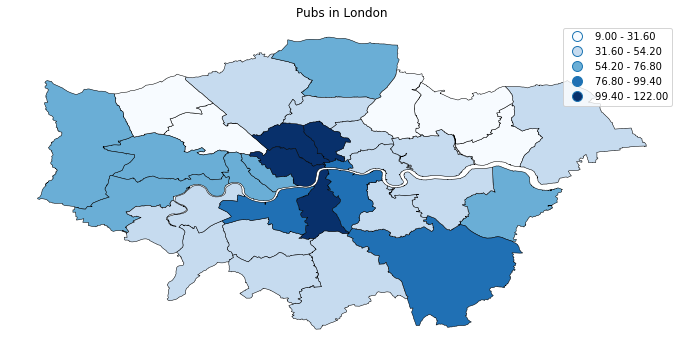

In [59]:
[fig,ax] = plt.subplots(1, figsize=(12, 8))

boroughs.plot(column='pub',cmap='Blues', edgecolor='black', linewidth=0.5, 
              legend=True, ax=ax, scheme='equal_interval');
ax.axis('off');
ax.set_title('Pubs in London');


A different way to visualize this is with a heatmap:

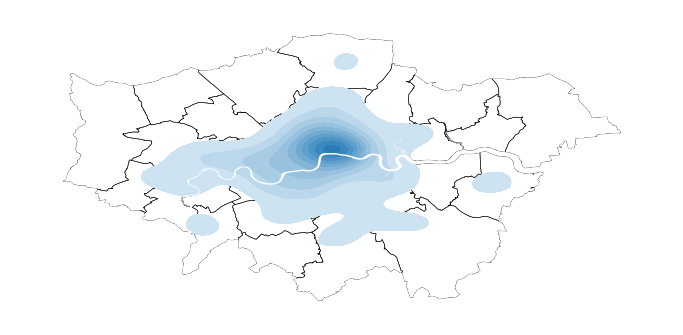

In [60]:
import geoplot 
[fig,ax] = plt.subplots(1, figsize=(12, 8))

geoplot.kdeplot(
    pubs, clip=boroughs.geometry, n_levels=10, 
    shade=True, cmap='Greens', ax=ax)
geoplot.polyplot(boroughs, ax=ax, alpha=1, edgecolor='black', linewidth=0.5)

<div class="alert alert-success">
 <b>EXERCISE</b> <br/> 
 Explore the data further with GeoPandas. Some suggestions of what to look at: <br/> 
   <ul>
  <li> Create a map that only shows all points of one of the POI classes for one of the boroughs.  </li>
  <li> Add another POI class to the boroughs table.</li>
  <li> Are the columns in the borough table related to any of the POI classes. Try making scatter plots or bar charts.  </li>     
  </ul> 
</div>  

In [ ]:
# your answers (add as many cells as you need)


Hopefully you got an idea of the possibilities with geospatial data now. There is a lot more to explore with this data. Let me know if you find anything interesting! I am on Twitter as @MargrietGr. 

### Author
Margriet Groenendijk is a Data & AI Developer Advocate for IBM. She develops and presents talks and workshops about data science and AI. She is active in the local developer communities through attending, presenting and organising meetups. She has a background in climate science where she explored large observational datasets of carbon uptake by forests during her PhD, and global scale weather and climate models as a postdoctoral fellow. 

Copyright © 2019 IBM. This notebook and its source code are released under the terms of the MIT License.

In [68]:
boroughs.columns

Index(['id', 'name', 'area_hectares', 'inner_statistical', 'geometry', 'all',
       'Area_name', 'Inner/_Outer_London', 'GLA_Population_Estimate_2017',
       'GLA_Household_Estimate_2017', 'Inland_Area_(Hectares)',
       'Population_density_(per_hectare)_2017', 'Average_Age,_2017',
       'Proportion_of_population_aged_0-15,_2015',
       'Proportion_of_population_of_working-age,_2015',
       'Proportion_of_population_aged_65_and_over,_2015',
       'Net_internal_migration_(2015)', 'Net_international_migration_(2015)',
       'Net_natural_change_(2015)',
       '%_of_resident_population_born_abroad_(2015)',
       'Largest_migrant_population_by_country_of_birth_(2011)',
       '%_of_largest_migrant_population_(2011)',
       'Second_largest_migrant_population_by_country_of_birth_(2011)',
       '%_of_second_largest_migrant_population_(2011)',
       'Third_largest_migrant_population_by_country_of_birth_(2011)',
       '%_of_third_largest_migrant_population_(2011)',
       '%_of_pop

In [69]:
%matplotlib inline

import matplotlib.pyplot as plt

In [70]:
import seaborn as sns

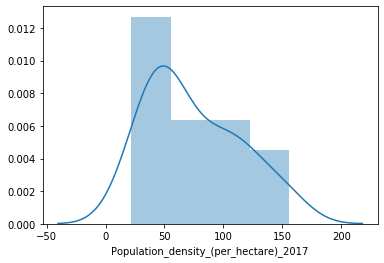

In [71]:
sns.distplot(boroughs['Population_density_(per_hectare)_2017'].dropna());

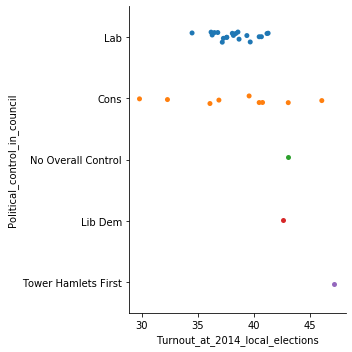

In [72]:
sns.catplot(x='Turnout_at_2014_local_elections', y='Political_control_in_council', data=boroughs);

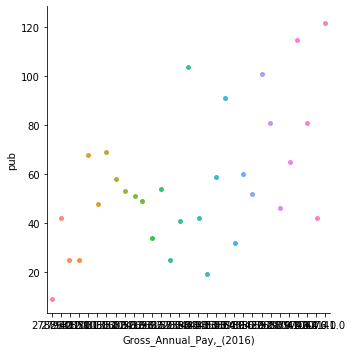

In [75]:
sns.catplot(x='Gross_Annual_Pay,_(2016)', y='pub', data=boroughs)

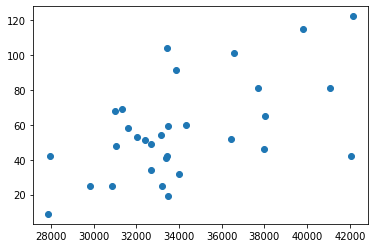

In [77]:
plt.scatter(boroughs['Gross_Annual_Pay,_(2016)'], boroughs['pub'])

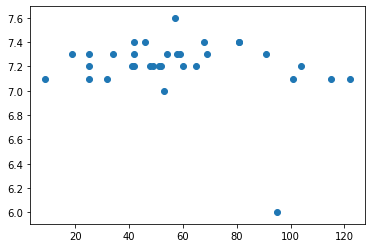

In [80]:
plt.scatter(boroughs['pub'], boroughs['Happiness_score_2011-14_(out_of_10)'])

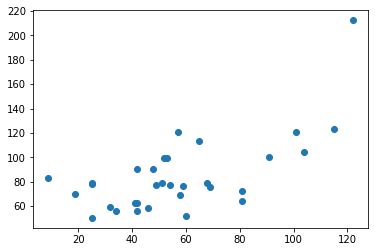

In [81]:
plt.scatter(boroughs['pub'], boroughs['Crime_rates_per_thousand_population_2014/15'])